In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import random
from utils.visualize_predictions import visualize_predictions
from utils.plot_training_validation import plot_training_validation
from utils.evaluation import evaluate_model
from utils.train import train_model

In [2]:
# CONSTANTS 

merged_dataset_dir = "../2_classes_merged_dataset"
# merged_dataset_dir = "../3_classes_merged_dataset"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LEARNING PARAMS
batch_size = 16
learning_rate = 5e-5
num_epochs = 3
img_size = 224

random.seed(42)
torch.manual_seed(42)

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=merged_dataset_dir, transform=train_transform)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensures all samples are used

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensures reproducible splits
)

# Apply different transforms to validation and test datasets
# Since random_split returns Subset objects, redefine them with new transforms
val_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    val_dataset.indices
)

test_dataset = Subset(
    datasets.ImageFolder(root=merged_dataset_dir, transform=test_val_transform),
    test_dataset.indices
)

# Create DataLoaders for each split
num_workers = 8  # Adjust based on your system's capabilities

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    num_workers=num_workers,
    pin_memory=True  # Speeds up data transfer to GPU if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for validation
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle for testing
    num_workers=num_workers,
    pin_memory=True
)

print(f"\nTotal samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 3166
Training samples: 2532
Validation samples: 316
Test samples: 318


In [ ]:

model = models.efficientnet_b0(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

for param in model.features[-3:].parameters():
    param.requires_grad = True

num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(full_dataset.classes))
)


model = model.to(device)


c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [6]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    gradient_clip=1.0,
    print_interval=10,
    save_dir="../saved_models/efficientnet",
    save_best=True,
    save_every_epoch=False,
)


Epoch 1/3 - Rozpoczynam trening:


Epoch 1: Train Loss: 0.4518 | Train Acc: 81.60%
Epoch 1 - Rozpoczynam walidację:


Walidacja:  85%|████████▌ | 17/20 [00:18<00:01,  1.92it/s]

Walidacja: Batch 10/20, Loss: 0.9718


Walidacja:  85%|████████▌ | 17/20 [00:18<00:01,  1.92it/s]

Walidacja: Batch 20/20, Loss: 0.4728


c:\Users\kubia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Val Loss: 0.3572 | Val Acc: 89.87%
Najlepszy model zapisany: ./saved_models\best_model.pth

Epoch 2/3 - Rozpoczynam trening:


Epoch 2: Train Loss: 0.2075 | Train Acc: 92.26%
Epoch 2 - Rozpoczynam walidację:


Walidacja:  85%|████████▌ | 17/20 [00:18<00:00,  3.20it/s]

Walidacja: Batch 10/20, Loss: 0.9616


Walidacja:  85%|████████▌ | 17/20 [00:18<00:00,  3.20it/s]

Walidacja: Batch 20/20, Loss: 0.1863


Epoch 2: Val Loss: 0.2745 | Val Acc: 92.41%
Najlepszy model zapisany: ./saved_models\best_model.pth

Epoch 3/3 - Rozpoczynam trening:


Epoch 3: Train Loss: 0.1774 | Train Acc: 93.40%
Epoch 3 - Rozpoczynam walidację:


Walidacja:  80%|████████  | 16/20 [00:18<00:01,  2.92it/s]

Walidacja: Batch 10/20, Loss: 0.8978


Walidacja:  95%|█████████▌| 19/20 [00:18<00:00,  3.92it/s]

Walidacja: Batch 20/20, Loss: 0.1366


Epoch 3: Val Loss: 0.2527 | Val Acc: 93.04%
Najlepszy model zapisany: ./saved_models\best_model.pth

Trening zakończony.


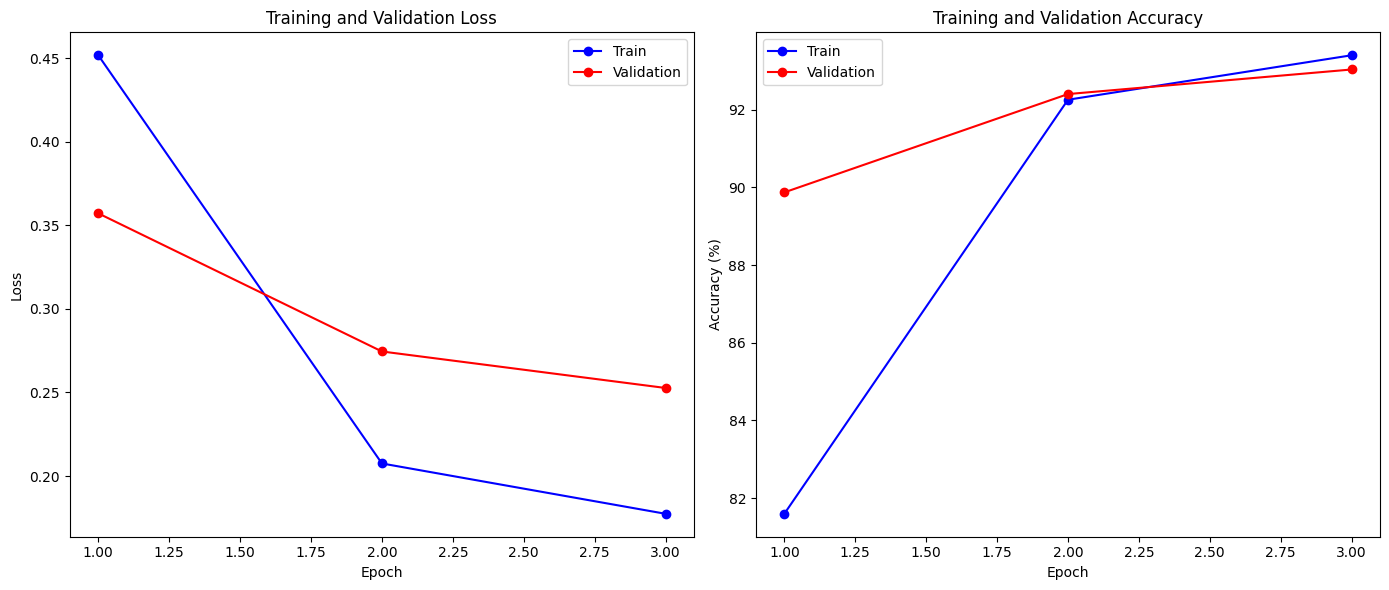

In [ ]:
plot_training_validation(
    history["train_loss"], history["val_loss"], history["train_acc"], history["val_acc"]
)


Test Loss: 0.1833 | Test Accuracy: 0.9465



Raport klasyfikacji:
               precision    recall  f1-score   support

      NORMAL       0.92      0.97      0.95       159
   PNEUMONIA       0.97      0.92      0.94       159

    accuracy                           0.95       318
   macro avg       0.95      0.95      0.95       318
weighted avg       0.95      0.95      0.95       318


Macierz konfuzji:
[[155   4]
 [ 13 146]]


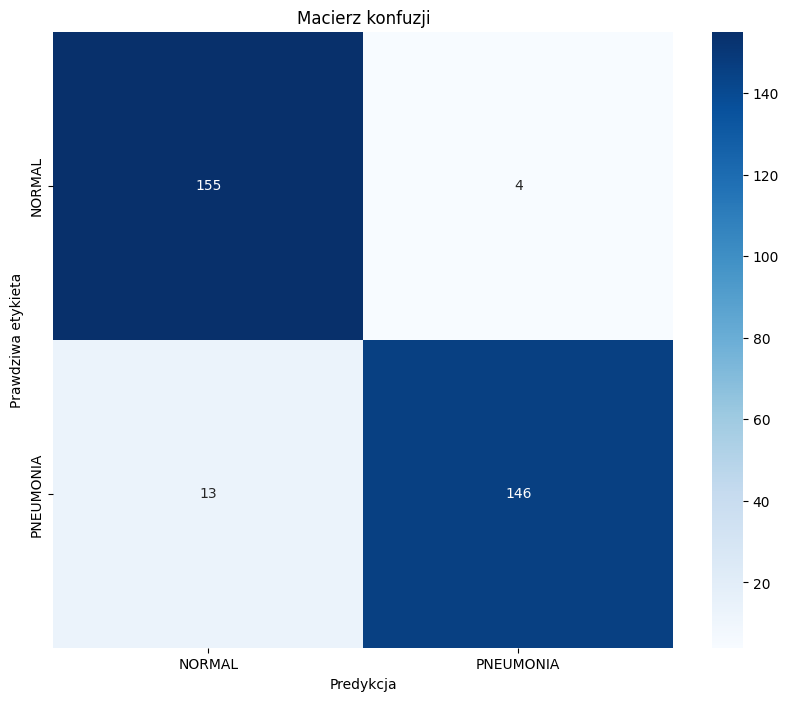

In [9]:
class_names = test_dataset.dataset.classes
evaluate_model(model, test_loader, criterion, device, class_names)

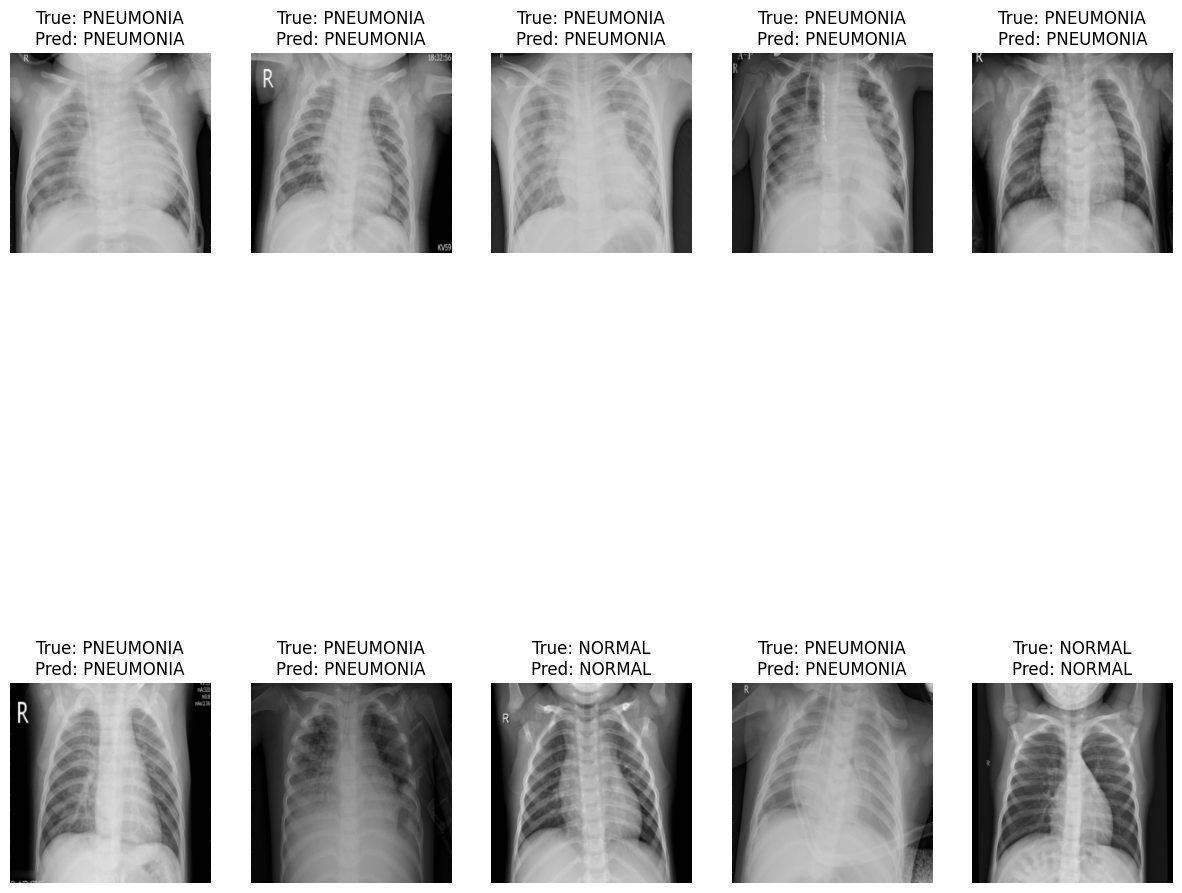

In [10]:
visualize_predictions(model, test_loader, class_names, device, num_images=10)